# Imports and definitions

In [1]:
### path_create_... con queste cartelle sotto
# Non ho capito

In [2]:
#from utils import *
from XRDXRFutils.notebook_utils import *
from paths_and_parameters import *

paths_to_create_delete = [subfolder_output, path_figures, path_results]

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [3]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for path_sel in paths_to_create_delete:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [4]:
for path_sel in paths_to_create_delete:
    if not isdir(path_sel):
        makedirs(path_sel)

# Read phase database

In [5]:
print('Reading phases from: ' + ', '.join(["'" + path + "'" for path in list_path_database]))
database = DatabaseXRD()
for path_database in list_path_database:
    database.read_cifs(path_database)
print(f'Total number of phases: {len(database)}')

Reading phases from: '../../shared/Database16_42/'
Total number of phases: 436


# Read XRD data
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [7]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)

data.rotate(steps_rotation_xrd)
y_x_ratio = data.shape[0] / data.shape[1]
print('\nShape of data\n-------------')
print(f'x: {data.shape[1]}, y: {data.shape[0]}, channels: {data.shape[2]}')
print('\nInitial calibration\n-------------------')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range: {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

Loading: ../../shared/dataXRDXRF/MuseoEgizio2022/MappaFioreSinistraMobiletto/XRD/Acquisition0001/xrd.h5

Shape of data
-------------
x: 35, y: 38, channels: 1280

Initial calibration
-------------------
a = -1327.1, s = 2729.8, beta = 43.202
Theta range: [17.27534463749343, 42.21348522241596]


### Correct burnt pixels
Substitute burnt pixel with the average of the non burnt ones.

In [7]:
qtl = 0.997

data.correct_quantile_pixels(qtl)

4 pixels out of 1330 were corrected.


# Read XRF element maps

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [8]:
data_xrf_elements = DataXRF().read_tiff(path_xrf_elements).flip(axis = xrf_axes_flip).rotate(steps_rotation_xrf_elements)
y_x_ratio = data_xrf_elements.labels.shape[0] / data_xrf_elements.labels.shape[1]
print(f'Found {data_xrf_elements.labels.shape[2]} images: ' + ', '.join([name for name in data_xrf_elements.metadata['labels']]))
print('\nShape of XRF element maps\n-------------------------')
print(f'x: {data_xrf_elements.labels.shape[1]}, y: {data_xrf_elements.labels.shape[0]}')

Found 14 images: images_Al_K, images_As_K, images_Ba_L, images_Ca_K, images_Cl_K, images_Cu_Kb, images_Fe_K, images_K_K, images_Mn_Ka, images_P_K, images_S_K, images_Si_K, images_Sr_K, images_Ti_K

Shape of XRF element maps
-------------------------
x: 35, y: 38


### Correct burnt pixels and wrong scale in each element map; also calculate normalized element maps
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [9]:
#qtl = 0.999

#data_xrf_elements.map_correct_specific_pixels([(0, 0)])
data_xrf_elements.map_correct_quantile_pixels(qtl).map_correct_scale()

maps_xrf_norm = data_xrf_elements.labels / data_xrf_elements.labels.max(axis = (0, 1), keepdims = True)

4 pixels out of 1330 were corrected on average in each XRF map.


# Select area

### Show phases with given elements
- `elements_chosen`: Elements that need to be in the selected phases.
- `elements_excluded`: Elements that must not be in the selected phases.

In [10]:
elements_chosen = ['Ca']
elements_excluded = []
# DO NOT EXCLUDE: Al, Ca, Cl, P, S, Si

df_phases = DataFrame(columns = ['Name in database', 'Chemical formula', 'N. of samples'])
for phase_name, phase_set in sorted(database.items()):
    p = phase_set[0]
    if '_chemical_formula_sum' in p:
        if (all(is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_chosen)
            and all(not is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_excluded)):
            df_phases.loc[len(df_phases)] = [phase_name, p['_chemical_formula_sum'], len(phase_set)]
elements_excluded = []
df_phases

,Name in database,Chemical formula,N. of samples
0,Attakolite,Al4 Ca H5 Mn O20 P3 Si,1
1,Ca Cu Si4 O10,Ca Cu O10 Si4,1
2,Calcite,C Ca O3,37
3,Carbonate-hydroxylapatite,C0.26 Ca5 O13.686 P2.829,1
4,Conichalcite,As Ca Cu H O5,4
5,Copper silicate,Ca Cu Si4 O10,1
6,Cuprorivaite,Ca Cu O10 Si4,1
7,Gypsum,Ca H4 O6 S,1
8,Huntite,C4 Ca Mg3 O12,1
9,Lazurite,Al2.97 Ca0.8 Mg0.36 Na3.12 O15.12 S Si3.03,4


### Show area given by XRF threshold
- `threshold_XRF_intensity`: The routine selects pixels where the first of `elements_chosen` has an XRF intensity above this threshold value.

Element chosen for the map of XRF intensity: images_Ca_K
Threshold: 0.45
Selected pixels: 287


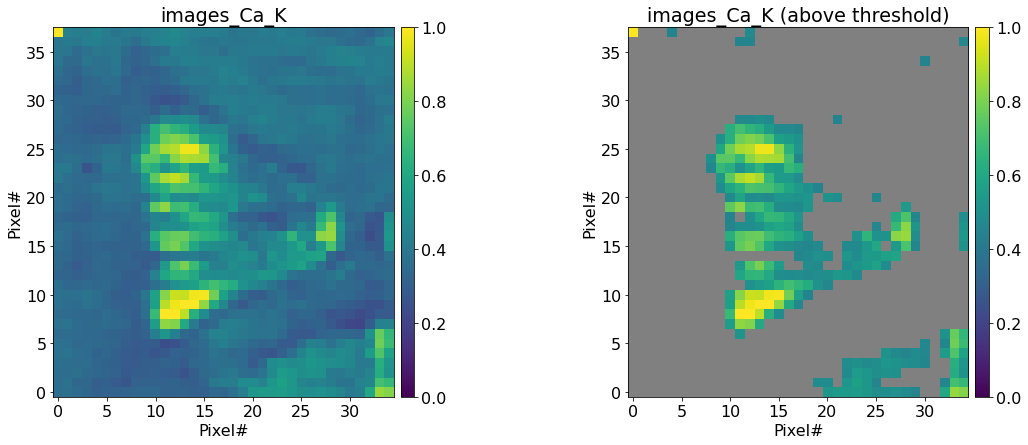

In [11]:
rcParams['font.size'] = 16

threshold_XRF_intensity = 0.45

###

idx_element_threshold = find_element(elements_chosen[0], data_xrf_elements.metadata['labels'])
print('Element chosen for the map of XRF intensity: ' + data_xrf_elements.metadata['labels'][idx_element_threshold])
print(f'Threshold: {threshold_XRF_intensity}')

indices_XRF_sel = zeros(data_xrf_elements.labels.shape[:2], bool)
for x in range(data_xrf_elements.labels.shape[1]):
    for y in range(data_xrf_elements.labels.shape[0]):
        if maps_xrf_norm[y, x, idx_element_threshold] >= threshold_XRF_intensity:
            indices_XRF_sel[y, x] = True
print(f'Selected pixels: {indices_XRF_sel.sum()}')

map_for_search = maps_xrf_norm[..., idx_element_threshold].copy()
map_for_search[~indices_XRF_sel] = nan

fig, axs = subplots(1, 2, figsize = (16, 6))
fig.tight_layout(w_pad = 2)
cmap_viridis = get_cmap('viridis').copy()
cmap_viridis.set_bad(color = 'grey')

ax = axs[0]
im = ax.imshow(maps_xrf_norm[..., idx_element_threshold], interpolation = 'none', vmin = 0, vmax = 1)
colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')
ax.set_title(data_xrf_elements.metadata['labels'][idx_element_threshold])

ax = axs[1]
im = ax.imshow(map_for_search, interpolation = 'none', vmin = 0, vmax = 1, cmap = cmap_viridis)
colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')
ax.set_title(data_xrf_elements.metadata['labels'][idx_element_threshold] + ' (above threshold)')

show()

### Select area: 3 options

In [12]:
# All the area of the scan
indices_sel = ones(data.shape[:2], bool)

In [12]:
# Only pixels where XRF intensity is above threshold
indices_sel = indices_XRF_sel

In [11]:
# Rectangular subset of the scan
x_min, x_max = 90, 139
y_min, y_max = 20, 69
indices_sel = zeros(data.shape[:2], bool)
for x in range(data.shape[1]):
    for y in range(data.shape[0]):
        if ((x >= x_min) and (x <= x_max) and (y >= y_min) and (y <= y_max)):
            indices_sel[y, x] = True

# Select primary phases

### Manually select phases

In [13]:
P1 = database['Huntite'][0].select_peaks([]) #[i for i in range(15) if i != 3]
P2 = database['Orpiment'][0].select_peaks([])
P3 = database['Cuprorivaite'][0].select_peaks([])
P4 = database['Atacamite'][0].select_peaks([])

phases_primary = [P1,P2,P3,P4]

### Take phases from file `phases_selection_primary.dat`

In [17]:
phases_primary = phases_from_file(subfolder_output + 'phases_selection_primary.dat', database)

Loaded phases: Ca Cu Si4 O10 0, Copper silicate 0, Cuprorivaite 0


### Set parameters of synthetic XRD patterns
You can skip this cell and keep the preset values of the parameters.

In [14]:
min_theta = 17
max_theta = 42
min_intensity = 0.05    # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = 7   # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.12           # sigma used in the peaks of synthetic diffraction patterns

### Check the number of tabulated peaks given by chosen parameters

In [17]:
#### Se non sceglo picchi mi segna un numero se scelgo picchi numero non congruente. Ad es huntite 7 picchi, se scelgo i pimi 5 la tabella dice 2 picchi
# Questo succede perché 3 dei primi 5 picchi stanno fuori dall'intervallo angolare scelto.
# Al momento la scelta dei picchi è implementata cosí:
# - ogni picco ha un indice assegnato da 0 a n, in ordine d'intensità, considerando tutti i picchi senza limitare l'intevallo angolare.
# - min_theta e max_theta selezionano in base all'angolo.
# - min_intensity seleziona in base all'intensità.
# - first_n_peaks seleziona solo quei picchi il cui indice è minore del valore scelto

In [15]:
df_phases = DataFrame(columns = ['Phase', 'N. of selected peaks'])
for i, p in enumerate(phases_primary):
    df_phases.loc[i] = [p.label, len(p.get_theta(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)[0])]
df_phases

,Phase,N. of selected peaks
0,Huntite,3
1,Orpiment,7
2,Cuprorivaite,7
3,Atacamite,4


# Search for primary phases

### Process experimental XRD pattern

In [16]:
window_snip = 32        # width of the window used for determining the background (default 32)
offset_background = 15  # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 1          # degree of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)

data = data.remove_background(window_snip = window_snip, offset_background = offset_background).smooth_channels(std_smooth)

Removing background...
Done.
Smoothing along channels...
Done.


### Change initial calibration

In [17]:
#data.opt = array([-1208.08149362, 1948.24846333, 51.66346438])

### Autocalibration and search
Optimizes on $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [17]:
%%time

phase_presence_method = 'adjustment_ratio'
# 'overlap_area', 'overlap_area_ratio', 'adjustment_ratio'

gm = GammaMap().from_data(data, phases_primary, indices_sel, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)
gm = gm.search(method = phase_presence_method)

Using 8 CPUs
CPU times: user 1.35 s, sys: 197 ms, total: 1.55 s
Wall time: 3.51 s


#### Fast mapping

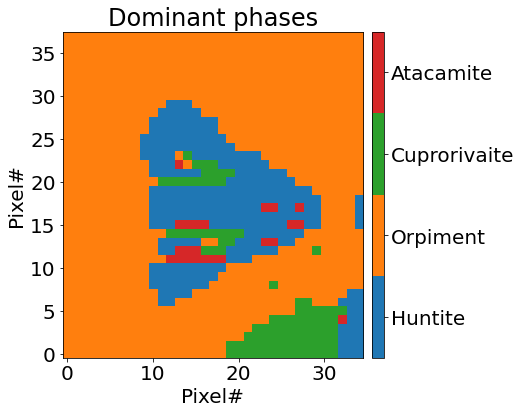

In [18]:
%matplotlib inline
rcParams['font.size'] = 20

fig, ax = subplots(figsize = (10, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(gm.phases) + 0.5, 1), len(gm.phases))
im = ax.imshow(gm.selected(), interpolation = 'none', cmap = cmap_chosen, norm = norm_chosen)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(gm.phases)))
cbar.set_ticklabels([p.label for p in gm.phases])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

savefig(path_figures + 'fast_map_dominant_phases.png', bbox_inches = 'tight', dpi = 200)
show()

### Inspect pixel

Huntite: overlap ratio = 0.428 ; adjustment ratio = 0.384


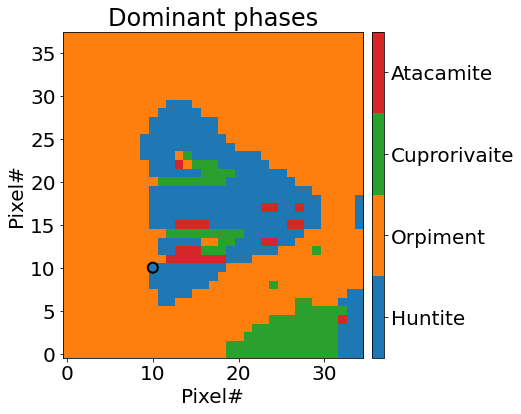

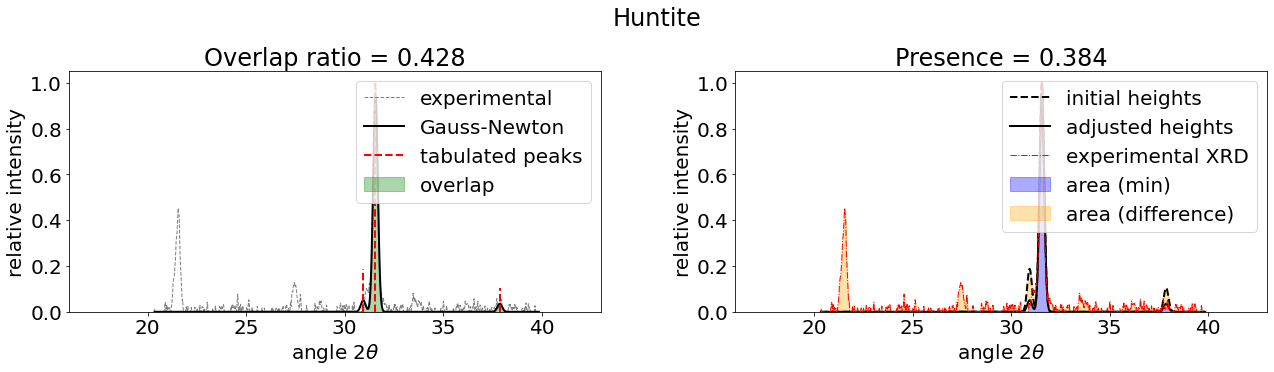

Orpiment: overlap ratio = 0.541 ; adjustment ratio = 0.188


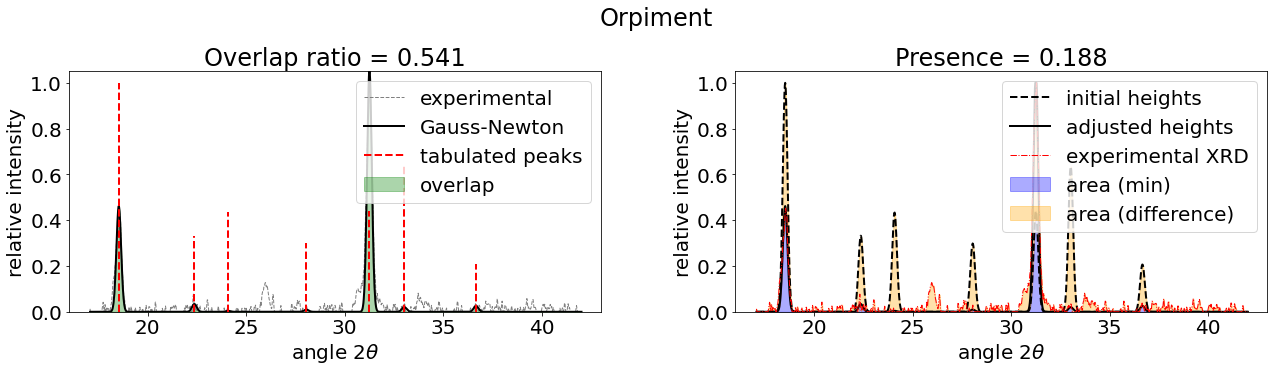

Cuprorivaite: overlap ratio = 0.073 ; adjustment ratio = 0.029


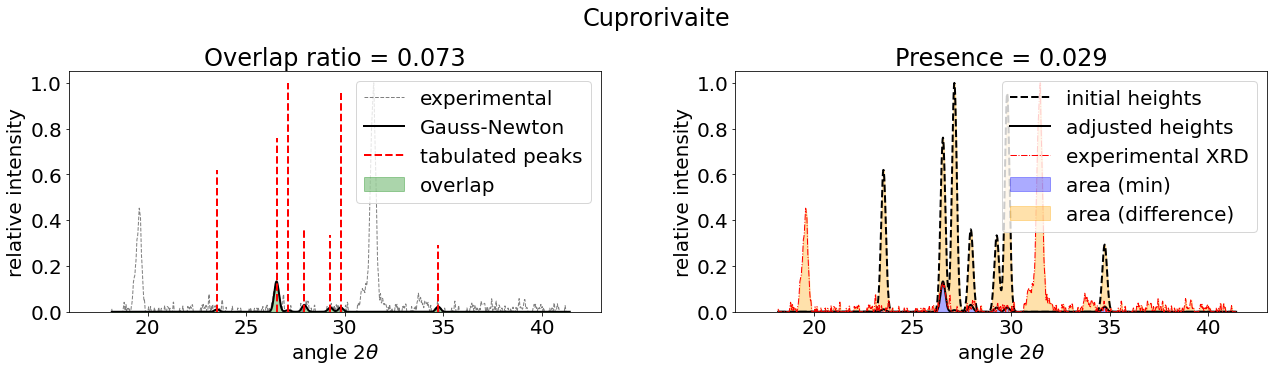

Atacamite: overlap ratio = 0.401 ; adjustment ratio = 0.205


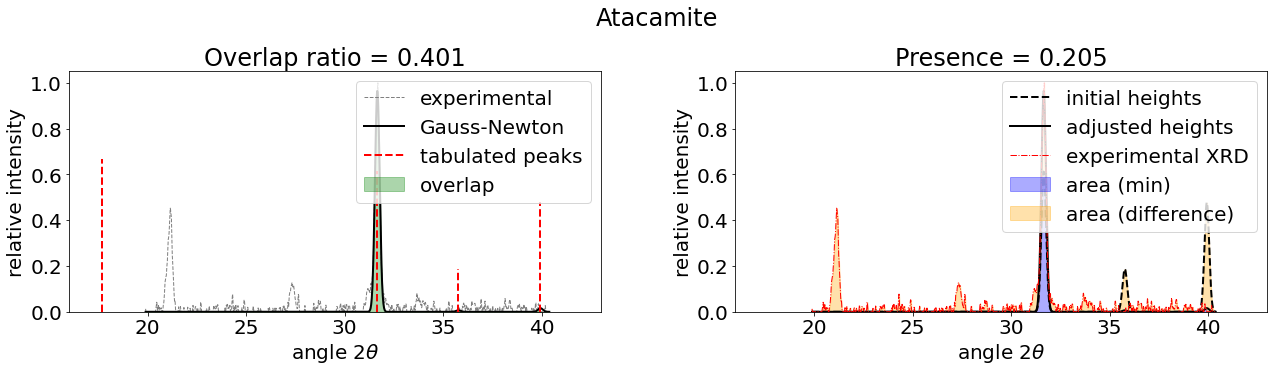

In [19]:
x, y = 10, 10

###

fig, ax = subplots(figsize = (10, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(gm.phases) + 0.5, 1), len(gm.phases))
im = ax.imshow(gm.selected(), interpolation = 'none', cmap = cmap_chosen, norm = norm_chosen)
ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'black', facecolors = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(gm.phases)))
cbar.set_ticklabels([p.label for p in gm.phases])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

gs = GammaSearch(gm.phases, FastSpectraXRD().from_Data(data, x, y), sigma,
    min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
gs.fit_cycle(steps = 2, gamma = True, alpha = 1, downsample = 3)
gs.fit_cycle(steps = 6, a = True, s = True, gamma = True, alpha = 1, downsample = 3)
gs.fit_cycle(steps = 2, a = True, s = True, gamma = True, alpha = 1, downsample = 2)

for i in range(len(gs)):
    gn = gs[i]
    print(f'{gn.phase.label}: overlap ratio = {gn.overlap_area_ratio():.3f} ; adjustment ratio = {gn.adjustment_ratio():.3f}')
    
    z0 = clip(gn.z0(), None, 1)
    z = clip(gn.z(), None, 1)
    z_stack = stack((z0, z, gn.intensity))
    z_min = z_stack.min(axis = 0)
    z_max = z_stack.max(axis = 0)
    overlap = z_min.sum() / z_max.sum()

    fig, axs = subplots(1, 2, figsize = (18, 5))
    fig.tight_layout(w_pad = 4)
    fig.subplots_adjust(top = 0.8)   # To shift the title
    
    ax = axs[0]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
    gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
    gn.phase.plot(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity,
        first_n_peaks = first_n_peaks, lw = 2, alpha = 1, label = 'tabulated peaks')
    ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta - 1, max_theta + 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'Overlap ratio = {gn.overlap_area_ratio():.3f}')
    
    ax = axs[1]
    ax.plot(gn.theta, z0, c = 'black', ls = '--', lw = 2, label = 'initial heights')
    ax.plot(gn.theta, z, c = 'black', ls = '-', lw = 2, label = 'adjusted heights')
    ax.plot(gn.theta, gn.intensity, c = 'red', ls = '-.', lw = 1, label = 'experimental XRD')
    ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'area (min)')
    ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'area (difference)')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta - 1, max_theta + 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel('relative intensity')
    ax.set_title(f'Presence = {overlap:.3f}')
    
    fig.suptitle(gn.phase.label)
    
    savefig(f'{path_figures}{clean_phase_name(phase_name)} - check fit.png', bbox_inches = 'tight', dpi = 300)
    show()
    close(fig)

# Quantify phase presence

In [20]:
### cosa c'è negli altre immagini che rimangono vuote? fasi che non sono definite?

In [21]:
%%time

phase_presence_method = 'adjustment_ratio'
phase_presence_correction = False
# ('overlap_area', True), ('overlap_area_ratio', False), ('adjustment_ratio', False)

phase_presence = gm.phase_presence(method = phase_presence_method, correction = phase_presence_correction)

Using 8 CPUs
CPU times: user 453 ms, sys: 95.2 ms, total: 548 ms
Wall time: 2.14 s


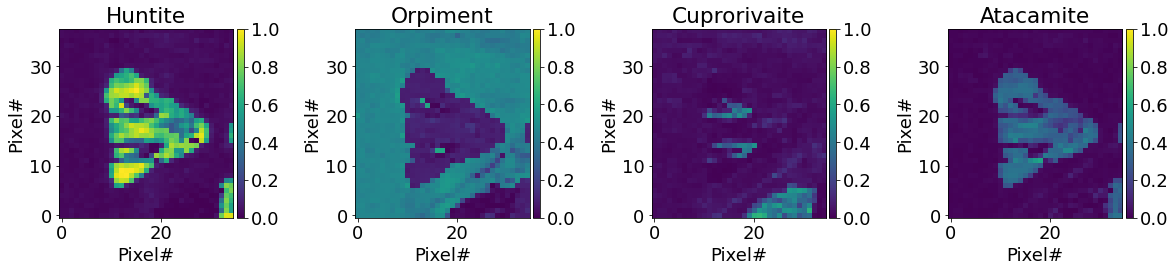

In [22]:
%matplotlib inline
n_of_columns = 4
rcParams['font.size'] = 18

set_nan_as_0 = True

###

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (4 * n_of_columns, 6 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 4)
cmap_viridis = get_cmap('viridis').copy()
cmap_viridis.set_bad(color = 'grey')
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]

    matrix_plot = phase_presence[..., i] / nanmax(phase_presence)
    #matrix_plot = phase_presence[..., i] / nanmax(phase_presence[..., i])
    if set_nan_as_0:
        matrix_plot[isnan(matrix_plot)] = 0
    im = ax.imshow(matrix_plot, interpolation = 'none', cmap = cmap_viridis, vmin = 0, vmax = 1)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
    ax.set_title(phase.label)
    ax.set_xlabel(r'Pixel#')
    ax.set_ylabel(r'Pixel#')

show()

### Save maps as PNG and TIF

In [52]:
rcParams['font.size'] = 14

for i, phase in enumerate(gm.phases):
    matrix_plot = phase_presence[..., i] / nanmax(phase_presence)
    #matrix_plot = phase_presence[..., i] / nanmax(phase_presence[..., i])
    matrix_plot[isnan(matrix_plot)] = 0
    matrix_tiff = flip((matrix_plot * 65535).astype('uint16'), axis = [0])
    
    fig, ax = subplots(figsize = (5, 3))
    im = imshow(matrix_plot, interpolation = 'none', vmin = 0, vmax = 1)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(phase.label)
    fig.set_dpi(80)
    savefig(path_figures + 'primary - ' + phase.label + ' - presence.png',
                bbox_inches = 'tight', dpi = 600)

    img = Image.fromarray(matrix_tiff)
    img.save(path_results + 'primary - ' + phase.label + ' - presence BW.tiff')
    img.save(path_figures + 'primary - ' + phase.label + ' - presence BW.png')

    close(fig)

# Explore one pixel with fitted primary phases
- You can select phases that have all the given elements
- The pixel to analyse can be selected manually, or automatically from XRF map, or automatically from phase presence

In [33]:
### come viene calcolata la presenza?

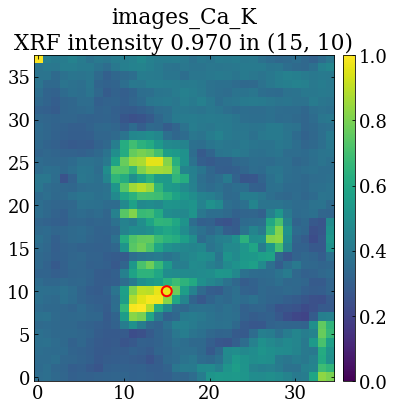

,XRF element,XRF intensity,Phase,Phase presece,Phase overlap ratio,"(x, y)"
0,images_Ca_K,0.970,Huntite 0,0.945,0.693,"(15, 10)"


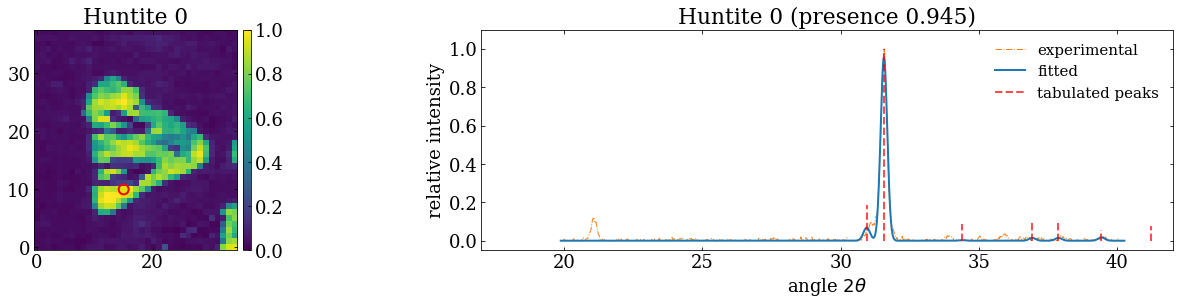

In [32]:
from numpy import nan

rcParams['font.size'] = 18

elements_chosen = ['Ca'] # Only phases with these elements will be selected

#selection_of_x_y = 'manual'               # Manually select the pixel
selection_of_x_y = 'from XRF'             # Automatically select the pixel in which the first element chosen has maximum XRF intensity
#selection_of_x_y = 'from phase presence'  # Automatically select for each phase the pixel in which the phase has maximum presence
n_th_best_pixel = 5

x, y = 20, 40

###

cmap_viridis = get_cmap('viridis').copy()
cmap_viridis.set_bad(color = 'grey')

selection_phases = zeros(len(gm.phases), dtype = bool)
for i, phase in enumerate(gm.phases):
    if '_chemical_formula_sum' in phase:
        if all(e in phase['_chemical_formula_sum'] for e in elements_chosen):
            selection_phases[i] = True

i_element = find_element(elements_chosen[0], data_xrf_elements.metadata['labels'])
if i_element is None:
    print(f'Could not find element \'{elements_chosen[0]}\' among XRF element images.')
else:
    map_xrf = maps_xrf_norm[..., i_element]
    #maps_phase_presence = phase_presence / nanmax(phase_presence, axis = (0, 1), keepdims = True)
    maps_phase_presence = phase_presence / nanmax(phase_presence)

    df_stats = DataFrame(columns = ['XRF element', 'XRF intensity', 'Phase', 'Phase presece', 'Phase overlap ratio', '(x, y)'])

    if selection_of_x_y == 'from XRF':
        map_xrf_flattened = gm.format_as_1d_from_2d(map_xrf)
        indices_sorted = map_xrf_flattened.argsort()
        indices_sorted_clean = indices_sorted[: (~isnan(map_xrf_flattened)).sum()]
        position = flip(indices_sorted_clean)[n_th_best_pixel]
        x, y = gm.get_x_y(position)
        
        map_xrf_restricted = map_xrf.copy()
        map_xrf_restricted[~gm.indices_sel] = nan
        fig, ax = subplots(figsize = (6, 6))
        ax.imshow(map_xrf_restricted, interpolation = 'none', cmap = cmap_viridis, vmin = 0, vmax = 1)
        cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
        ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
        ax.set_title(data_xrf_elements.metadata['labels'][i_element] + f'\nXRF intensity {map_xrf[y, x]:.3f} in {(x, y)}')
        show()


    if (selection_phases.sum() > 0):
        fig, axs = subplots(selection_phases.sum(), 2, figsize = (18, 4 * selection_phases.sum()),
                       gridspec_kw = {'width_ratios': [1, 2]})
        fig.tight_layout(h_pad = 5, w_pad = 7)

        j = 0
        for i, phase in enumerate(gm.phases):
            if selection_phases[i]:

                if selection_of_x_y == 'from phase presence':
                    map_presence_flattened = gm.format_as_1d_from_2d(maps_phase_presence[..., i])
                    indices_sorted = map_presence_flattened.argsort()
                    indices_sorted_clean = indices_sorted[: (~isnan(map_presence_flattened)).sum()]
                    position = flip(indices_sorted_clean)[n_th_best_pixel]
                    x, y = gm.get_x_y(position)

                g = gm.get_pixel(x, y)[i]
                if (selection_phases.sum() > 1):
                    ax = axs[j, 0]
                else:
                    ax = axs[0]
                sca(ax)
                im = ax.imshow(maps_phase_presence[..., i], interpolation = 'none', cmap = cmap_viridis, vmin = 0, vmax = 1)
                cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
                #cbar.set_label('overlap')
                ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
                ax.set_title(phase.label)

                if (selection_phases.sum() > 1):
                    ax = axs[j, 1]
                else:
                    ax = axs[1]
                sca(ax)
                g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
                g.plot(c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
                #g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
                g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks',
                    min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
                ax.set_xlim(min_theta, max_theta)
                ax.set_ylim(-0.05, 1.1)
                ax.set_xlabel(r'angle $2\theta$')
                ax.set_ylabel(r'relative intensity')
                ax.set_title(f'{phase.label} (presence {maps_phase_presence[y, x, i]:.3f})')
                ax.legend(frameon = False)
                df_stats.loc[len(df_stats)] = [
                    data_xrf_elements.metadata['labels'][i_element], map_xrf[y, x], phase.label, maps_phase_presence[y, x, i], g.overlap_area_ratio(), (x, y)
                ]
                j += 1

    display(df_stats.style.format({'XRF intensity': '{:.3f}', 'Phase presece': '{:.3f}', 'Phase overlap ratio': '{:.3f}'}))
    show()

# Select secondary phases

### Manually select them

In [39]:
#S1 = database['Metacinnabar'][1]
#S2 = database['Metahalloysite'][0]
#S3 = database['Sodalite'][20]
#S4 = database['Barite'][0]
#S5 = database['Goethite'][15]
#S6 = database['Hematite'][9]
#S7 = database['Hematite'][0]

S1 = database['Bone_Black'][0]
S2 = database['Goethite'][0]
S3 = database['Hematite'][4]

phases_secondary = [S1, S2, S3]

### Take them from file `phases_selection_secondary.dat`

In [24]:
phases_secondary = phases_from_file(subfolder_output + 'phases_selection_secondary.dat', database)

Loaded phases: Crocoite 2


# Search for secondary phases

### Set parameters of synthetic phases
You can skip this cell and keep the preset values of the parameters.

In [40]:
min_theta = 20
max_theta = 53
min_intensity = 0.1           # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks_secondary = 5   # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.2                   # sigma used in the peaks of synthetic diffraction patterns

### Check the number of tabulated peaks given by chosen parameters

In [41]:
df_phases = DataFrame(columns = ['Phase', 'N. of selected peaks'])
for i, p in enumerate(phases_secondary):
    df_phases.loc[i] = [p.label, len(p.get_theta(min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks_secondary)[0])]
df_phases

,Phase,N. of selected peaks
0,Bone_Black,5
1,Goethite,4
2,Hematite,4


### Smooth data along pixels

In [42]:
step = 2
method = 'mean'
#method = 'max'

data_smooth = (
    data
    .generate_spatial_smooth(step, method)
    .remove_background(window_snip = window_snip, offset_background = offset_background)
    .smooth_channels(std_smooth)
)

Generating smooth data...
Done.
Removing background...
Done.
Smoothing along channels...
Done.


### Refit primary phases on smoothed data

In [44]:
%%time

gm1 = GammaMap().from_data(data_smooth, phases_primary, indices_sel, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)
gm1 = gm1.search(method = phase_presence_method)
phase_presence_1 = gm1.phase_presence(method = phase_presence_method, correction = phase_presence_correction)

Using 8 CPUs
Using 8 CPUs
CPU times: user 34.5 s, sys: 5.63 s, total: 40.1 s
Wall time: 59.9 s


### Fit secondary phases on smoothed data

You can choose how many peaks to consider in secondary phases

In [45]:
%%time

gm2 = GammaMap_Secondary().from_data(gm1, phases_secondary, sigma = sigma, min_theta = min_theta,
    max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks_secondary)
gm2 = gm2.fit_cycle(steps = 6, gamma = True)
overlap_area_difference_ratio_2 = gm2.overlap_area_difference()

phase_presence_2 = overlap_area_difference_ratio_2 * (data_smooth.rescaling**0.5)

Using 8 CPUs
CPU times: user 39.7 s, sys: 5.75 s, total: 45.4 s
Wall time: 49.7 s


# Plots

### Primary phases

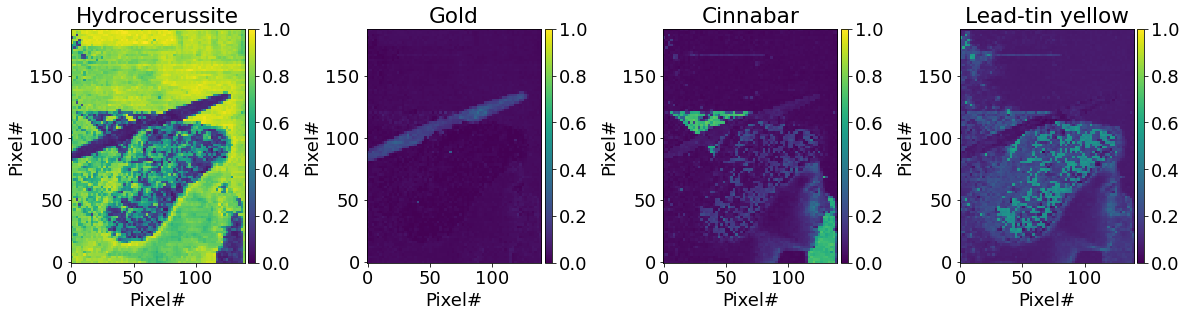

In [46]:
%matplotlib inline
n_of_columns = 4
rcParams['font.size'] = 18

set_nan_as_0 = True

###

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (4 * n_of_columns, 6 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 4)
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]

    matrix_plot = phase_presence_1[..., i] / nanmax(phase_presence_1)
    #matrix_plot = phase_presence_1[..., i] / nanmax(phase_presence_1[..., i])
    if set_nan_as_0:
        matrix_plot[isnan(matrix_plot)] = 0
    im = ax.imshow(matrix_plot, interpolation = 'none', cmap = cmap_viridis, vmin = 0, vmax = 1)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
    ax.set_title(phase.label)
    ax.set_xlabel(r'Pixel#')
    ax.set_ylabel(r'Pixel#')

show()

### Secondary phases

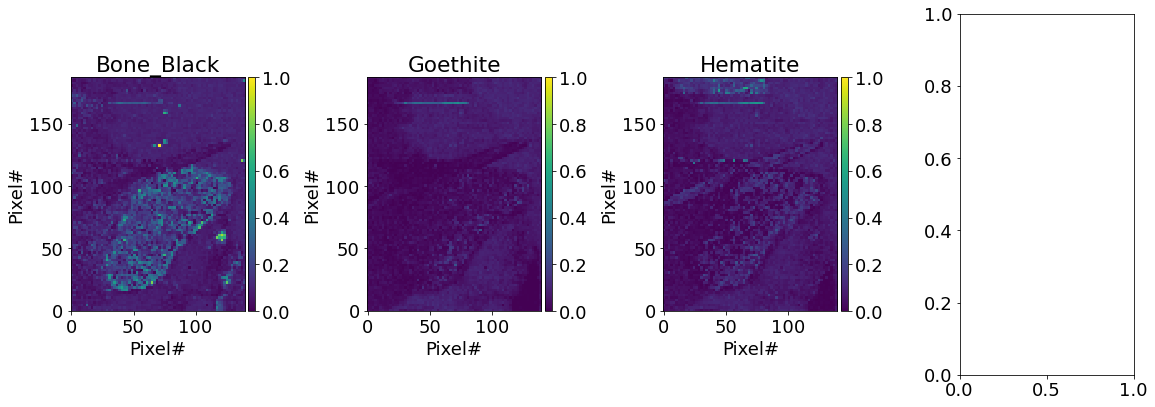

In [47]:
%matplotlib inline
n_of_columns = 4
rcParams['font.size'] = 18

set_nan_as_0 = True

###

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (4 * n_of_columns, 6 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 4)
for i, phase in enumerate(gm2.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]

    matrix_plot = phase_presence_2[..., i] / nanmax(phase_presence_2)
    #matrix_plot = phase_presence_2[..., i] / nanmax(phase_presence_2[..., i])
    if set_nan_as_0:
        matrix_plot[isnan(matrix_plot)] = 0
    im = ax.imshow(matrix_plot, interpolation = 'none', cmap = cmap_viridis, vmin = 0, vmax = 1)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
    ax.set_title(phase.label)
    ax.set_xlabel(r'Pixel#')
    ax.set_ylabel(r'Pixel#')

show()

### Save maps of secondary phases as PNG and TIF

In [48]:
rcParams['font.size'] = 14

for i, phase in enumerate(gm2.phases):
    matrix_plot = phase_presence_2[..., i] / nanmax(phase_presence_2)
    #matrix_plot = phase_presence_2[..., i] / nanmax(phase_presence_2[..., i])
    matrix_plot[isnan(matrix_plot)] = 0
    matrix_tiff = flip((matrix_plot * 65535).astype('uint16'), axis = [0])
    
    fig, ax = subplots(figsize = (5, 3))
    im = imshow(matrix_plot, interpolation = 'none', vmin = 0, vmax = 1)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(phase.label)
    fig.set_dpi(80)
    savefig(path_figures + 'secondary - ' + phase.label + ' - presence.png',
                bbox_inches = 'tight', dpi = 600)

    img = Image.fromarray(matrix_tiff)
    img.save(path_results + 'secondary - ' + phase.label + ' - presence BW.tiff')
    img.save(path_figures + 'secondary - ' + phase.label + ' - presence BW.png')

    close(fig)

# Explore phases in a pixel given by element selection

### List of phases

In [34]:
DataFrame({
    'Category': ['Primary'] * len(phases_primary) + ['Secondary'] * len(phases_secondary),
    'Phase': [p.label for p in phases_primary + phases_secondary],
    'Chemical formula': [p['_chemical_formula_sum'] if '_chemical_formula_sum' in p.keys() else '-' for p in phases_primary + phases_secondary]
})

NameError: name 'phases_secondary' is not defined

### Exploration
- The procedure analyses all the phases that have at least one of the elements of `elements_allowed`.
- Also, it selects only pixels where all of `elements_allowed` have an XRF intensity of at least `threshold_min_xrf`.
- The procedure selects the pixel where the first of `elements_allowed` has the maximum XRF intensity. This can be modulated with `quantile_xrf`: when it is set to 1, it means we search the maximum value; for lower values, we search for the given quantile of XRF intensity; when it is set to 0, we search for the minimum value.

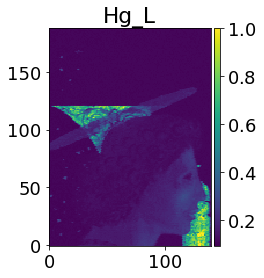

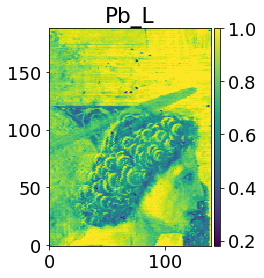

Threshold 0.200 applied as minimum to the following XRF maps: Hg_L, Pb_L.
Selected 3477 pixels over 26320.
Hg_L used to search for 0.900 quantile of XRF intensity.
Chosen coordinates: (135, 8). XRF intensity in the pixel: 0.741


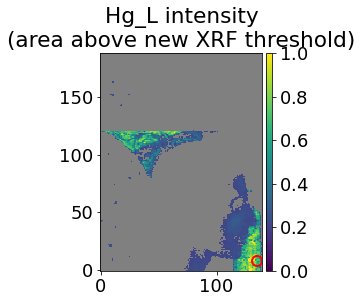

,Category,Phase,Overlap ratio
0,Primary,Hydrocerussite,0.171
1,Primary,Cinnabar,0.706
2,Primary,Lead-tin yellow,0.167


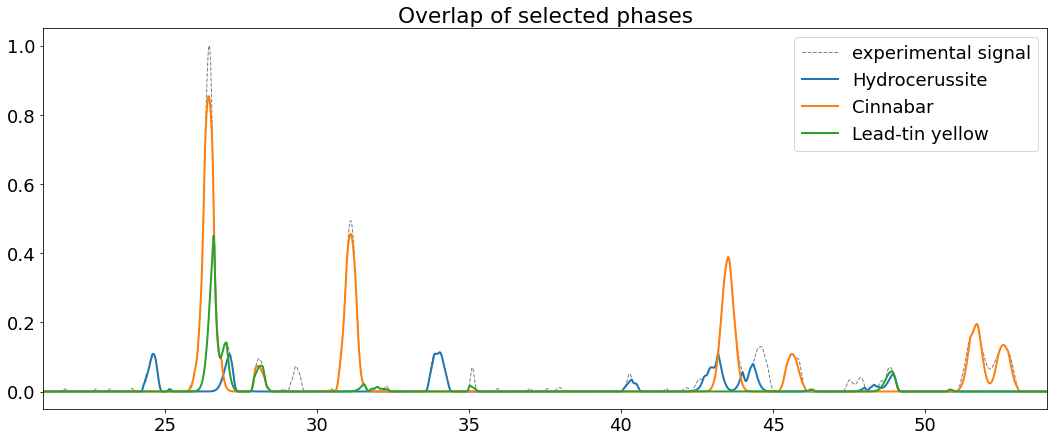

In [50]:
### View options ###

rcParams['font.size'] = 18


### Select phases ###

elements_allowed = ['Hg', 'Pb']   # Select phases that have at least one of the elements
#exclude_phase_names = ['Cinnabar']   # Names of phases that will be excluded from the plot
exclude_phase_names = []   # Leave as empty list to have no excluded phases


### Select pixels ###

threshold_min_xrf = 0.2   # Minimum XRF intensity required to all of elements_allowed
quantile_xrf = 0.9


### Redo the fit ###

redo_fit = False
window_snip = 32         # Width of the window used for determining the background (default 32)
offset_background = 10   # Value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 3           # Degree of the final smooth applied to the XRD pattern (default 0)
min_theta = 20
max_theta = 53
min_intensity = 0.1  # Among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = 5    # Selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.2          # Sigma used in the peaks of synthetic diffraction patterns


###

cmap_viridis = get_cmap('viridis').copy()
cmap_viridis.set_bad(color = 'grey')

indices_elements_allowed = []
for e in elements_allowed:
    i = find_element(e, data_xrf_elements.metadata['labels'])
    if i is not None:
        indices_elements_allowed.append(i)
        fig, ax = subplots(figsize = (6, 4))
        im = ax.imshow(maps_xrf_norm[..., i], interpolation = 'none', cmap = cmap_viridis)
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
        ax.set_title(data_xrf_elements.metadata['labels'][i])
        show()
    else:
        print("'" + e + "' not found among XRF phases.")

if len(indices_elements_allowed) > 0:

    map_xrf_selected = maps_xrf_norm[..., indices_elements_allowed[0]].copy()

    if (~gm.indices_sel).sum() > 0:
        print(f'The initial selection leaves {gm.n_pixels} pixels.')
        
        map_xrf_selected[~gm.indices_sel] = nan
        
        fig, ax = subplots(figsize = (6, 4))
        im = ax.imshow(map_xrf_selected, vmin = 0, vmax = 1, interpolation = 'none', cmap = cmap_viridis)
        #ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
        ax.set_title(data_xrf_elements.metadata['labels'][indices_elements_allowed[0]] + ' intensity\n(initial selection)')
        show()

    print(f'Threshold {threshold_min_xrf:.3f} applied as minimum to the following XRF maps: ' + ', '.join([data_xrf_elements.metadata['labels'][i] for i in indices_elements_allowed]) + '.')
    indices_sel_2 = zeros(data.shape[:2], bool)
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            if all(maps_xrf_norm[y, x, i] >= threshold_min_xrf for i in indices_elements_allowed):
                indices_sel_2[y, x] = True
    indices_sel_total = gm.indices_sel & indices_sel_2
    map_xrf_selected[~indices_sel_total] = nan
    print(f'Selected {indices_sel_total.sum()} pixels over {gm.n_pixels}.')

    if indices_sel_total.sum() > 0:
        print(f'{data_xrf_elements.metadata["labels"][indices_elements_allowed[0]]} used to search for {quantile_xrf:.3f} quantile of XRF intensity.')
        threshold_qtl_xrf = nanquantile(map_xrf_selected, quantile_xrf)
        map_xrf_qtl = map_xrf_selected.copy()
        map_xrf_qtl[map_xrf_qtl > threshold_qtl_xrf] = nan
        position = nanargmax(map_xrf_qtl.flatten())
        y, x = unravel_index(position, map_xrf_qtl.shape)
        print(f'Chosen coordinates: {(x, y)}. XRF intensity in the pixel: {map_xrf_qtl[y, x]:.3f}')

        fig, ax = subplots(figsize = (6, 4))
        im = ax.imshow(map_xrf_selected, vmin = 0, vmax = 1, interpolation = 'none', cmap = cmap_viridis)
        ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
        ax.set_title(data_xrf_elements.metadata['labels'][indices_elements_allowed[0]] + ' intensity\n(area above new XRF threshold)')
        show()


        if redo_fit:
            spectrum_xrd = FastSpectraXRD().from_Data(data, x, y)
            spectrum_xrd.background_elimination_and_smoothing(window_snip = window_snip, offset_background = offset_background, std_smooth = std_smooth, avoid_negative = True)
            gs1 = GammaSearch(phases_primary, spectrum_xrd, sigma = sigma, min_theta = min_theta,
                              max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
            gs1.search()
            gs2 = GammaSearch_Secondary(gs1, phases_secondary, sigma = sigma, min_theta = min_theta,
                                        max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
            gs2 = gs2.fit_cycle(steps = 6, gamma = True)

        else:
            gs2 = gm2.get_pixel(x, y)

        df_overlaps = DataFrame(columns = ['Category', 'Phase', 'Overlap ratio'])
        fig, ax = subplots(figsize = (18, 7))
        theta = gs2.gammasearch_1[0].theta
        ax.plot(theta, gs2.intensity, c = 'grey', ls = '--', lw = 1, label = 'experimental signal')
        for j, phase in enumerate(phases_primary):
            if '_chemical_formula_sum' in phase:
                if phase.label not in exclude_phase_names:
                    if any(is_element_in_formula(e, phase['_chemical_formula_sum']) for e in elements_allowed):
                        ax.plot(theta, gs2.gammasearch_1.overlap()[j], ls = '-', lw = 2, label = phase.label)
                        df_overlaps.loc[len(df_overlaps)] = ['Primary', phase.label, gs2.gammasearch_1.overlap_area_ratio()[j]]
        for j, phase in enumerate(phases_secondary):
            if '_chemical_formula_sum' in phase:
                if phase.label not in exclude_phase_names:
                    if any(is_element_in_formula(e, phase['_chemical_formula_sum']) for e in elements_allowed):
                        ax.plot(theta, gs2.overlap()[j], ls = '-', lw = 2, label = phase.label)
                        df_overlaps.loc[len(df_overlaps)] = ['Secondary', phase.label, gs2.overlap_area_difference_ratio()[j]]

        display(df_overlaps.style.format({'Overlap ratio': '{:.3f}'}))
        ax.legend(frameon = True, loc = 'upper right')
        ax.set_xlim(theta[0], theta[-1])
        ax.set_title('Overlap of selected phases')
        show()

### Overlap of each secondary phases vs all primary phases

Primary phases: 0.872 of experimental area
Secondary phases – Fraction of experimental area covered by each secondary phase but not by primary phases
Bone_Black:	0.014
Goethite:	0.000
Hematite:	0.002


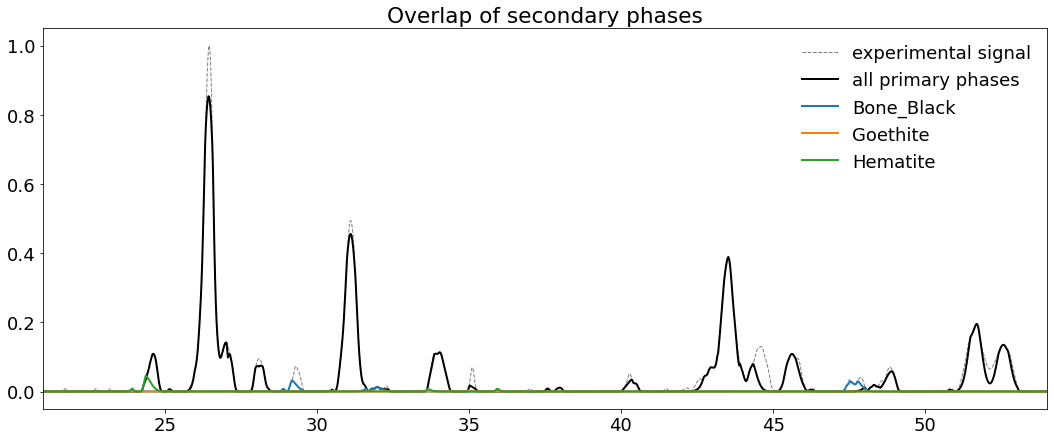

In [51]:
### View options ###

#exclude_phase_names = ['Bone_Black']   # Names of phases that will be excluded from the plot
exclude_phase_names = []   # Leave as empty list to have no excluded phases

###

fig, ax = subplots(figsize = (18, 7))
theta = gs2.gammasearch_1[0].theta
ax.plot(theta, gs2.intensity, c = 'grey', ls = '--', lw = 1, label = 'experimental signal')
ax.plot(theta, gs2.gammasearch_1.overlap_total(), c = 'black', ls = '-', lw = 2, label = 'all primary phases')
print(f'Primary phases: {gs2.gammasearch_1.overlap_total_ratio():.3f} of experimental area')
print('Secondary phases – Fraction of experimental area covered by each secondary phase but not by primary phases')
for j in range(len(gs2)):
    if gs2[j].phase.label not in exclude_phase_names:
        ax.plot(theta, gs2.overlap()[j], ls = '-', lw = 2, label = gs2[j].phase.label)
        print(f'{gs2[j].label}:\t{gs2.overlap_area_difference_ratio()[j]:.3f}')

legend(frameon = False)
ax.set_xlim(theta[0], theta[-1])
ax.set_title('Overlap of secondary phases')
show()